In [1]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [2]:
train_path="/content/drive/MyDrive/Colab Notebooks/DL-Project/Train"
test_path="/content/drive/MyDrive/Colab Notebooks/DL-Project/Test"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)
print(class_names)
print(class_names_test)
dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/DL-Project/Test')
print(dir)
file_path = ('/content/drive/MyDrive/Colab Notebooks/DL-Project/Test')
print(file_path)
#os.rmdir('/content/drive/MyDrive/DL- Project/test/.ipynb_checkpoints')
print(dir)
dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/DL-Project/Train')
print(dir)
file_path = ('/content/drive/MyDrive/Colab Notebooks/DL-Project/Train')
print(file_path)
#os.rmdir('/content/drive/MyDrive/DL- Project/train/.ipynb_checkpoints')
print(dir)

['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
/content/drive/MyDrive/Colab Notebooks/DL-Project/Test
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
/content/drive/MyDrive/Colab Notebooks/DL-Project/Train
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']


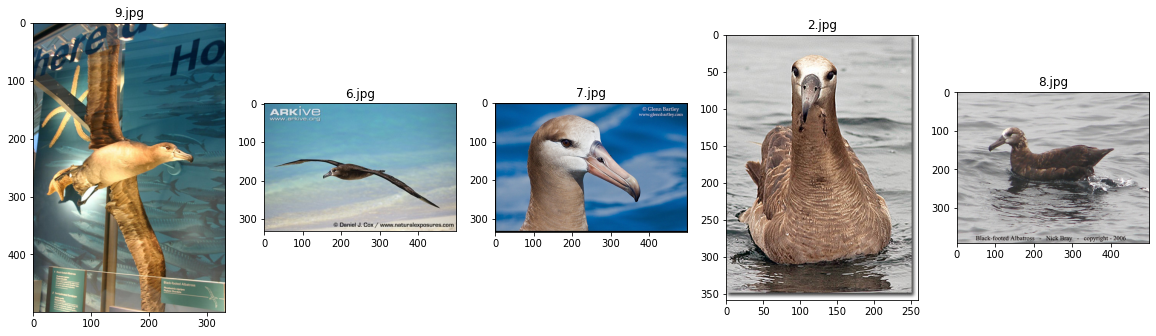

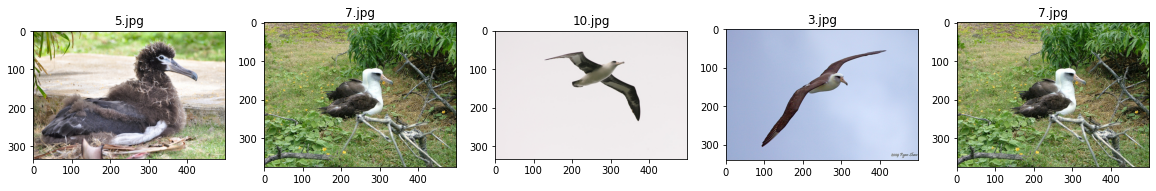

In [3]:
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random

# First folder codes
plt.figure(figsize=(20,20))
test_folder=r'/content/drive/MyDrive/Colab Notebooks/DL-Project/Test'
img_folder="/content/drive/MyDrive/Colab Notebooks/DL-Project/Test/bird1"
#os.rmdir('/content/drive/MyDrive/test/test1/.ipynb_checkpoints')
for i in range(5):
    file = random.choice(os.listdir("/content/drive/MyDrive/Colab Notebooks/DL-Project/Test/bird1"))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# second folder codes
img_folder="/content/drive/MyDrive/Colab Notebooks/DL-Project/Test/bird2"
#os.rmdir('/content/drive/MyDrive/test/test2/.ipynb_checkpoints')
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir("/content/drive/MyDrive/Colab Notebooks/DL-Project/Test/bird2"))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [4]:

train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,rotation_range=5,brightness_range=(0,0.5),horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DL-Project/Train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='categorical')
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DL-Project/Test",target_size=(224,224),batch_size=32,shuffle=False,class_mode='categorical')

Found 433 images belonging to 10 classes.
Found 110 images belonging to 10 classes.


In [5]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [6]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [7]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [11]:
base_model = ResNet50(input_shape=(224, 224, 3))


headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(10,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

model = Model(inputs=base_model.input, outputs=headModel)


In [13]:
base_model = ResNet50(input_shape=(224, 224, 3))


headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(10,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

model = Model(inputs=base_model.input, outputs=headModel)

import matplotlib.pyplot as plt
model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])
history = model.fit(train_generator, verbose=1, validation_data = test_generator, epochs=1)


14/14 [==============================] - 326s 23s/step - loss: 29.3973 - accuracy: 0.0855 - val_loss: 4.2769 - val_accuracy: 0.0909


In [10]:
model.save('/content/drive/MyDrive/Colab Notebooks/DL-Project/basemodel-300.pkl')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/DL-Project/basemodel-300.pkl/assets


In [ ]:
model.summary()

In [14]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/DL-Project/basemodel-300.pkl')

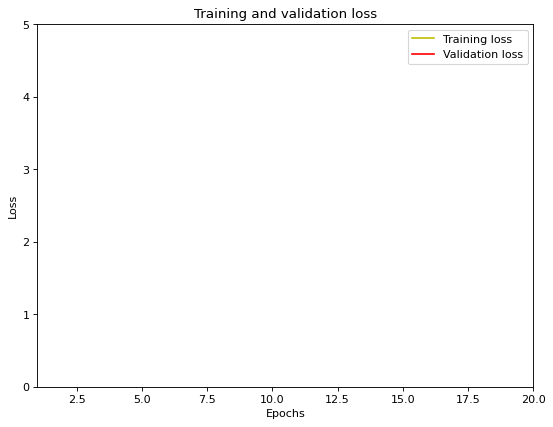

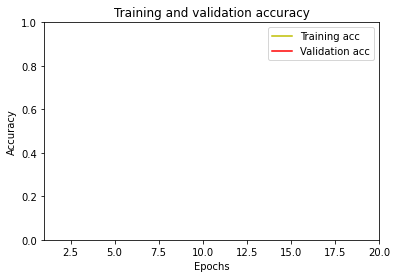

[0.08545034378767014]


In [15]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlim(1,20)
plt.ylim(0,5)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlim(1,20)
plt.ylim(0,1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(acc)

In [16]:
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/DL-Project/Test/bird1/0.jpg',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255

classes = class_labels
print(classes)
proba = model.predict(img.reshape(1,224,224,3))
top_10 = np.argsort(proba[0])[:-11:-1]
for i in range(10):
    print("{}".format(classes[top_10[i]])+" ({:.3})".format(proba[0][top_10[i]]))
plt.imshow(img)

NameError: ignored

In [17]:
import numpy as np
import sklearn.metrics as metrics
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator,test_steps_per_epoch)
# Get most likely class
predictions = np.argmax(predictions, axis=-1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predictions, target_names=class_labels)
print(report)
confusion_matrix = metrics.confusion_matrix(true_classes, predictions)  # shape=(12, 12)
print(confusion_matrix)

              precision    recall  f1-score   support

       bird1       0.44      0.73      0.55        11
      bird10       0.52      1.00      0.69        11
       bird2       0.20      0.09      0.13        11
       bird3       0.40      0.36      0.38        11
       bird4       0.43      0.55      0.48        11
       bird5       0.50      0.09      0.15        11
       bird6       1.00      0.27      0.43        11
       bird7       0.57      0.36      0.44        11
       bird8       0.38      0.55      0.44        11
       bird9       0.36      0.45      0.40        11

    accuracy                           0.45       110
   macro avg       0.48      0.45      0.41       110
weighted avg       0.48      0.45      0.41       110

[[ 8  0  0  1  0  0  0  1  1  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 3  0  1  0  2  0  0  0  3  2]
 [ 5  0  1  4  0  0  0  0  0  1]
 [ 0  0  1  0  6  0  0  0  0  4]
 [ 0  5  0  2  0  1  0  1  2  0]
 [ 0  0  0  2  1  0  3  1  2  2]
 [ 0  4  0

['bird1', 'bird10', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9']
bird7 (0.0287)
bird3 (0.000555)
bird5 (6.22e-05)
bird2 (5.29e-05)
bird1 (1.64e-05)
bird10 (2.34e-11)
bird9 (1.43e-11)
bird8 (5.72e-12)
bird6 (8.82e-13)
bird4 (2.49e-15)


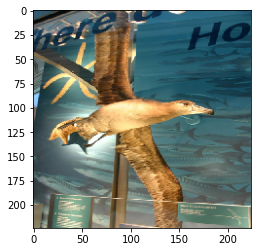

In [21]:
img = image.load_img('//content/drive/MyDrive/Colab Notebooks/DL-Project/Test/bird1/9.jpg',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255

classes = class_labels
print(classes)
proba = model.predict(img.reshape(1,224,224,3))
top_10 = np.argsort(proba[0])[:-11:-1]
for i in range(10):
    print("{}".format(classes[top_10[i]])+" ({:.3})".format(proba[0][top_10[i]]))
plt.imshow(img)

In [ ]:
model.predict(test_generator)

array([[9.9991047e-01, 9.5109937e-07, 2.6370127e-02, 9.2116141e-01,
        1.2494783e-05, 6.5005003e-07, 5.6456310e-01, 2.2055685e-05,
        1.6431168e-02, 8.2915771e-04],
       [1.2208593e-06, 9.9859852e-01, 9.7432869e-12, 2.9020987e-06,
        6.7854434e-01, 5.8552070e-04, 7.7776775e-08, 1.9948129e-05,
        8.5951008e-02, 6.0461421e-02],
       [4.4969771e-02, 6.1344317e-06, 9.9929607e-01, 1.9068711e-01,
        7.6831229e-06, 2.1329920e-03, 3.0874217e-01, 9.3023675e-03,
        3.5569891e-02, 7.5202878e-03],
       [1.5660655e-05, 4.3557331e-11, 1.3078730e-07, 9.9999988e-01,
        2.0820593e-07, 1.2919003e-09, 7.9799658e-03, 9.9913224e-09,
        9.7649115e-01, 3.5029683e-02],
       [1.1457597e-12, 4.4013251e-07, 1.5933041e-06, 6.0018635e-07,
        9.9999869e-01, 2.6245994e-10, 1.9610864e-14, 8.8253862e-13,
        9.2171698e-10, 1.7179413e-02],
       [1.0275448e-02, 3.8723945e-07, 5.3502804e-06, 8.7223519e-03,
        1.9463626e-07, 9.9999809e-01, 1.9613545e-02, 4.29

In [22]:
import numpy as np
import tensorflow as tf
import os
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Multiply,GlobalAveragePooling2D, Add, Dense, Activation, Flatten, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Lambda
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
#eras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K

In [24]:
train_path="/content/drive/MyDrive/Colab Notebooks/DL/train"
test_path="/content/drive/MyDrive/Colab Notebooks/DL/test"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)
print(class_names)
print(class_names_test)
dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/DL/test')
print(dir)
file_path = ('/content/drive/MyDrive/Colab Notebooks/DL/test')
print(file_path)
#os.rmdir('/content/drive/MyDrive/Colab Notebooks/DL/test/.ipynb_checkpoints')
print(dir)
dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/DL/train')
print(dir)
file_path = ('/content/drive/MyDrive/Colab Notebooks/DL/train')
print(file_path)
#os.rmdir('/content/drive/MyDrive/Colab Notebooks/DL/train/.ipynb_checkpoints')
print(dir)
dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/DL/predict')
print(dir)
file_path = ('/content/drive/MyDrive/Colab Notebooks/DL/predict')
print(file_path)
#os.rmdir('/content/drive/MyDrive/Colab Notebooks/DL/predict/.ipynb_checkpoints')
print(dir)

['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
/content/drive/MyDrive/Colab Notebooks/DL/test
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
/content/drive/MyDrive/Colab Notebooks/DL/train
['bird1', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
['bird1', 'bird3', 'bird4', 'bird2', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']
/content/drive/MyDrive/Colab Notebooks/DL/predict
['bird1', 'bird3', 'bird4', 'bird2', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9', 'bird10']


In [25]:
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,rotation_range=5,brightness_range=(0,0.5),horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
prediction_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DL/train",target_size=(224,224),color_mode='rgb',batch_size=32,shuffle=True,class_mode='categorical')
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DL/test",target_size=(224,224),color_mode='rgb',batch_size=2,shuffle=False,class_mode='categorical')
prediction_generator = prediction_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/DL/predict",target_size=(224,224),color_mode='rgb',batch_size=2,shuffle=False,class_mode='categorical')

Found 543 images belonging to 10 classes.
Found 166 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


In [26]:
def res_conv(X, filters, base, s):
    
    name_base = base + '/branch'
    
    F1, F2, F3 = filters

    ##### Branch1 is the main path and Branch2 is the shortcut path #####
    
    X_shortcut = X
    
    ##### Branch1 #####
    # First component of Branch1 
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_1')(X)
    X= Activation('relu', name=name_base + '1/relu_1')(X)
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)

    # Second component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_2')(X)
    X = Activation('relu', name=name_base + '1/relu_2')(X)
    X = Conv2D(filters=F2, kernel_size=(3,3), strides=(s,s), padding='same', name=name_base + '1/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Third component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_3')(X)
    X = Activation('relu', name=name_base + '1/relu_3')(X)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_3', kernel_initializer=glorot_uniform(seed=0))(X)
    
    ##### Branch2 ####
    X_shortcut = BatchNormalization(axis=-1, name=name_base + '2/bn_1')(X_shortcut)
    X_shortcut= Activation('relu', name=name_base + '2/relu_1')(X_shortcut)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', name=name_base + '2/conv_1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    
    # Final step: Add Branch1 and Branch2
    X = Add(name=base + '/Add')([X, X_shortcut])

    return X


In [27]:
def res_identity(X, filters, base):
    
    name_base = base + '/branch'
    
    F1, F2, F3 = filters

    ##### Branch1 is the main path and Branch2 is the shortcut path #####
    
    X_shortcut = X
    
    ##### Branch1 #####
    # First component of Branch1 
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_1')(X)
    Shortcut= Activation('relu', name=name_base + '1/relu_1')(X)
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_1', kernel_initializer=glorot_uniform(seed=0))(Shortcut)

    # Second component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_2')(X)
    X = Activation('relu', name=name_base + '1/relu_2')(X)
    X = Conv2D(filters=F2, kernel_size=(3,3), strides=(1,1), padding='same', name=name_base + '1/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Third component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_3')(X)
    X = Activation('relu', name=name_base + '1/relu_3')(X)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_3', kernel_initializer=glorot_uniform(seed=0))(X)    
    
    # Final step: Add Branch1 and the original Input itself
    X = Add(name=base + '/Add')([X, X_shortcut])

    return X

In [28]:
def Trunk_block(X, F, base):
    
    name_base = base
    
    X = res_identity(X, F, name_base + '/Residual_id_1')
    X = res_identity(X, F, name_base + '/Residual_id_2')
    
    return X

In [29]:
def interpolation(input_tensor, ref_tensor,name): # resizes input_tensor wrt. ref_tensor
    H, W = ref_tensor.get_shape()[1], ref_tensor.get_shape()[2]
    return tf.image.resize (input_tensor, [H, W],name=name)

In [30]:
def Attention_1(X, filters, base):
    
    F1, F2, F3 = filters
    
    name_base = base
    
    X = res_identity(X, filters, name_base+ '/Pre_Residual_id')
    
    X_Trunk = Trunk_block(X, filters, name_base+ '/Trunk')
    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_3')(X)
    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_3_Down')
    
    Residual_id_3_Down_shortcut = X
    
    Residual_id_3_Down_branched = res_identity(X, filters, name_base+ '/Mask/Residual_id_3_Down_branched')
    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_2')(X)
    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Down')
    
    Residual_id_2_Down_shortcut = X
    
    Residual_id_2_Down_branched = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Down_branched')
    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_1')(X)
    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Down')
    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Up')
    
    temp_name1 = name_base+ "/Mask/Interpool_1"
    
    X = Lambda(interpolation, arguments={'ref_tensor': Residual_id_2_Down_shortcut,'name':temp_name1})(X)
                                          
    X = Add(name=base + '/Mask/Add_after_Interpool_1')([X, Residual_id_2_Down_branched])
                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Up')
    
    temp_name2 = name_base+ "/Mask/Interpool_2"
    
    X = Lambda(interpolation, arguments={'ref_tensor': Residual_id_3_Down_shortcut,'name':temp_name2})(X)
                                          
    X = Add(name=base + '/Mask/Add_after_Interpool_2')([X, Residual_id_3_Down_branched])
                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_3_Up')
    
    temp_name3 = name_base+ "/Mask/Interpool_3"
    
    X = Lambda(interpolation, arguments={'ref_tensor': X_Trunk,'name':temp_name3})(X)
                                          
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_3/bn_1')(X)
                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_3/relu_1')(X)
                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_3/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)
    
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_3/bn_2')(X)
                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_3/relu_2')(X)
                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_3/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    X = Activation('sigmoid', name=name_base+'/Mask/sigmoid')(X)
      
    X = Multiply(name=name_base+'/Mutiply')([X_Trunk,X])
    
    X = Add(name=name_base+'/Add')([X_Trunk,X])

    X = res_identity(X, filters, name_base+ '/Post_Residual_id')
    
    return X


In [31]:
def Attention_2(X, filters, base):
    
    F1, F2, F3 = filters
    
    name_base = base
    
    X = res_identity(X, filters, name_base+ '/Pre_Residual_id')
    
    X_Trunk = Trunk_block(X, filters, name_base+ '/Trunk')
    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_2')(X)
    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Down')
    
    Residual_id_2_Down_shortcut = X
    
    Residual_id_2_Down_branched = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Down_branched')
    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_1')(X)
    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Down')
                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Up')
    
    temp_name1 = name_base+ "/Mask/Interpool_1"
    
    X = Lambda(interpolation, arguments={'ref_tensor': Residual_id_2_Down_shortcut,'name':temp_name1})(X)
                                          
    X = Add(name=base + '/Mask/Add_after_Interpool_1')([X, Residual_id_2_Down_branched])
                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Up')
    
    temp_name2 = name_base+ "/Mask/Interpool_2"
    
    X = Lambda(interpolation, arguments={'ref_tensor': X_Trunk,'name':temp_name2})(X)
                                          
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_2/bn_1')(X)
                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_2/relu_1')(X)
                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_2/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)
    
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_2/bn_2')(X)
                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_2/relu_2')(X)
                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_2/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    X = Activation('sigmoid', name=name_base+'/Mask/sigmoid')(X)
      
    X = Multiply(name=name_base+'/Mutiply')([X_Trunk,X])
    
    X = Add(name=name_base+'/Add')([X_Trunk,X])

    X = res_identity(X, filters, name_base+ '/Post_Residual_id')
    
    return X


In [32]:
def Attention_3(X, filters, base):
    
    F1, F2, F3 = filters
    
    name_base = base
    
    X = res_identity(X, filters, name_base+ '/Pre_Residual_id')
    
    X_Trunk = Trunk_block(X, filters, name_base+ '/Trunk')
    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_1')(X)
    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Down')
                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Up')
    
    temp_name2 = name_base+ "/Mask/Interpool_1"
    
    X = Lambda(interpolation, arguments={'ref_tensor': X_Trunk,'name':temp_name2})(X)
                                          
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_2/bn_1')(X)
                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_2/relu_1')(X)
                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_2/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)
    
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_2/bn_2')(X)
                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_2/relu_2')(X)
                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_2/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    X = Activation('sigmoid', name=name_base+'/Mask/sigmoid')(X)
      
    X = Multiply(name=name_base+'/Mutiply')([X_Trunk,X])
    
    X = Add(name=name_base+'/Add')([X_Trunk,X])

    X = res_identity(X, filters, name_base+ '/Post_Residual_id')
    
    return X


In [ ]:
input_shape=(224,224,3)
X_input = Input(input_shape)

X = Conv2D(64, (7,7), strides=(2,2), padding='same', name='conv_1', kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=-1, name='bn_1')(X)
X = Activation('relu', name='relu_1')(X)
X = MaxPooling2D((3,3), strides=(2,2), padding='same' ,name='pool_1')(X)
X = res_conv(X, [64,64,256], 'Residual_conv_1', 1)

### Attention 1 Start
X = Attention_1(X, [64,64,256], 'Attention_1')
### Attention 1 End

X = res_conv(X, [128,128,512], 'Residual_conv_2', 2)

### Attention 2 Start
X = Attention_2(X, [128,128,512], 'Attention_2')
### Attention 2 End

X = res_conv(X, [256,256,1024], 'Residual_conv_3', 2)

### Attention 3 Start
X = Attention_3(X, [256,256,1024], 'Attention_3')
### Attention 3 End

X = res_conv(X, [512,512,2048], 'Residual_conv_4', 2)

X = res_identity(X, [512,512,2048], 'Residual_id_1')
X = res_identity(X, [512,512,2048], 'Residual_id_2')
X = BatchNormalization(axis=-1, name='bn_2')(X)
X = Activation('relu', name='relu_2')(X)
X = AveragePooling2D((7,7), strides=(1,1), name='avg_pool')(X)
X = Flatten()(X)
X = Dense(10, name='Dense_1')(X)
X = Activation('softmax', name='classifier')(X)
model = Model(inputs=X_input, outputs=X, name='attention_56')
model.summary()

In [ ]:
import matplotlib.pyplot as plt
model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])
history = model.fit(train_generator, verbose=1,  batch_size=32, validation_data = test_generator, epochs=300)


In [37]:
import sys
sys.setrecursionlimit(20000)

In [38]:
model.save('/content/drive/MyDrive/Colab Notebooks/DL-Project/AttentionModel-300.pkl')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/DL-Project/AttentionModel-300.pkl/assets


TypeError: ignored

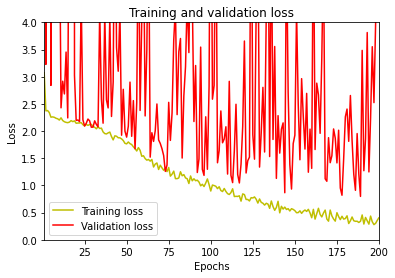

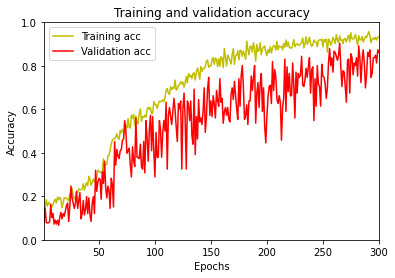

[0.12154696136713028, 0.15101289749145508, 0.18416206538677216, 0.15469613671302795, 0.1712707132101059, 0.16758747398853302, 0.1565377563238144, 0.15101289749145508, 0.1620626151561737, 0.17863720655441284, 0.1860036849975586, 0.16942909359931946, 0.19705340266227722, 0.18416206538677216, 0.19521178305149078, 0.18784530460834503, 0.147329643368721, 0.1712707132101059, 0.19337016344070435, 0.1915285438299179, 0.1915285438299179, 0.18416206538677216, 0.17863720655441284, 0.21178637444972992, 0.21362799406051636, 0.23756906390190125, 0.20441989600658417, 0.18784530460834503, 0.18968692421913147, 0.21915285289287567, 0.21731123328208923, 0.23388582468032837, 0.2302025854587555, 0.2302025854587555, 0.23388582468032837, 0.25782689452171326, 0.22836095094680786, 0.24861878156661987, 0.2633517384529114, 0.24861878156661987, 0.29097604751586914, 0.27808472514152527, 0.2504604160785675, 0.265193372964859, 0.2799263298511505, 0.26703497767448425, 0.27808472514152527, 0.28729280829429626, 0.32044

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlim(1,200)
plt.ylim(0,4)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlim(1,300)
plt.ylim(0,1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(acc,'\n')

probability=model.predict(prediction_generator)
print(probability)


In [42]:
import numpy as np
import sklearn.metrics as metrics
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator,test_steps_per_epoch)
# Get most likely class
predictions = np.argmax(predictions, axis=-1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predictions, target_names=class_labels)
print(report)
confusion_matrix = metrics.confusion_matrix(true_classes, predictions)  # shape=(12, 12)
print(confusion_matrix)

              precision    recall  f1-score   support

       bird1       0.92      0.75      0.83        16
      bird10       1.00      0.94      0.97        17
       bird2       0.75      0.92      0.83        13
       bird3       0.87      0.68      0.76        19
       bird4       0.60      1.00      0.75        15
       bird5       0.88      0.94      0.91        16
       bird6       0.88      0.88      0.88        17
       bird7       0.91      0.67      0.77        15
       bird8       0.95      1.00      0.98        20
       bird9       1.00      0.83      0.91        18

    accuracy                           0.86       166
   macro avg       0.88      0.86      0.86       166
weighted avg       0.88      0.86      0.86       166

[[12  0  1  2  1  0  0  0  0  0]
 [ 0 16  0  0  0  1  0  0  0  0]
 [ 0  0 12  0  1  0  0  0  0  0]
 [ 1  0  3 13  1  0  0  1  0  0]
 [ 0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  1  0]
 [ 0  0  0  0  2  0 15  0  0  0]
 [ 0  0  0

['bird1', 'bird10', 'bird2', 'bird3', 'bird4', 'bird5', 'bird6', 'bird7', 'bird8', 'bird9']
bird5 (0.995)
bird10 (0.00384)
bird8 (0.00111)
bird6 (9.4e-09)
bird9 (7.39e-10)
bird7 (5.92e-11)
bird2 (1.15e-11)
bird4 (6.75e-16)
bird3 (4.16e-17)
bird1 (2.14e-18)


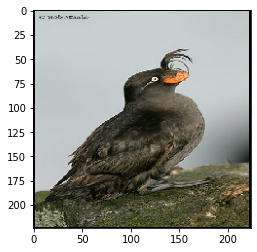

In [45]:
img = image.load_img('//content/drive/MyDrive/Colab Notebooks/DL-Project/Test/bird5/3.jpg',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255

classes = class_labels
print(classes)
proba = model.predict(img.reshape(1,224,224,3))
top_10 = np.argsort(proba[0])[:-11:-1]
for i in range(10):
    print("{}".format(classes[top_10[i]])+" ({:.3})".format(proba[0][top_10[i]]))
plt.imshow(img)

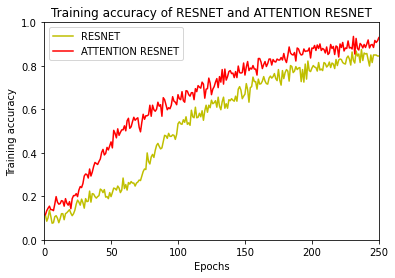

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
epochs = range(1, 251)
resnet_acc=[0.11316397041082382, 0.08545034378767014, 0.10161662846803665, 0.13625866174697876, 0.10854503512382507, 0.07621247321367264, 0.07852193713188171, 0.1062355637550354, 0.11085450649261475, 0.09930715709924698, 0.07852193713188171, 0.0969976931810379, 0.12009237706661224, 0.12009237706661224, 0.09237875044345856, 0.12009237706661224, 0.12471131980419159, 0.13163971900939941, 0.13856813311576843, 0.12240184843540192, 0.11085450649261475, 0.12009237706661224, 0.13625866174697876, 0.16397228837013245, 0.18244802951812744, 0.17321015894412994, 0.1593533456325531, 0.1870669722557068, 0.17090068757534027, 0.14549653232097626, 0.18937644362449646, 0.17551963031291962, 0.1778291016817093, 0.22401846945285797, 0.17321015894412994, 0.2124711275100708, 0.21016165614128113, 0.19861431419849396, 0.19168591499328613, 0.19861431419849396, 0.2032332569360733, 0.23325635492801666, 0.22863741219043732, 0.21709007024765015, 0.230946883559227, 0.19630484282970428, 0.19861431419849396, 0.18937644362449646, 0.21709007024765015, 0.19861431419849396, 0.21709007024765015, 0.23787528276443481, 0.23556582629680634, 0.22863741219043732, 0.2471131682395935, 0.23787528276443481, 0.21709007024765015, 0.22863741219043732, 0.2840646505355835, 0.23556582629680634, 0.2540415823459625, 0.22863741219043732, 0.26327943801879883, 0.2563510537147522, 0.2678983807563782, 0.26096996665000916, 0.26096996665000916, 0.2471131682395935, 0.26096996665000916, 0.2655889093875885, 0.2748267948627472, 0.2725173234939575, 0.2933025360107422, 0.31408774852752686, 0.3256351053714752, 0.32332563400268555, 0.3995380997657776, 0.3602771461009979, 0.34872978925704956, 0.3810623586177826, 0.39260968565940857, 0.3787528872489929, 0.41108545660972595, 0.4341801404953003, 0.443418025970459, 0.42956119775772095, 0.41801387071609497, 0.42263278365135193, 0.4526558816432953, 0.480369508266449, 0.4780600368976593, 0.4665127098560333, 0.48960739374160767, 0.47575056552886963, 0.47575056552886963, 0.48267897963523865, 0.480369508266449, 0.461893767118454, 0.4849884510040283, 0.5334873199462891, 0.542725145816803, 0.5334873199462891, 0.531177818775177, 0.5519630312919617, 0.5404157042503357, 0.5658198595046997, 0.531177818775177, 0.5381062626838684, 0.5265588760375977, 0.5958429574966431, 0.5658198595046997, 0.5612009167671204, 0.6096997857093811, 0.5612009167671204, 0.5635104179382324, 0.581986129283905, 0.5658198595046997, 0.5935335159301758, 0.5496535897254944, 0.5935335159301758, 0.6189376711845398, 0.5866050720214844, 0.6189376711845398, 0.607390284538269, 0.6420323252677917, 0.6258660554885864, 0.6304849982261658, 0.6397228837013245, 0.6096997857093811, 0.6558891534805298, 0.6143187284469604, 0.5981523990631104, 0.6351039409637451, 0.6558891534805298, 0.6050808429718018, 0.6258660554885864, 0.6050808429718018, 0.6443418264389038, 0.6397228837013245, 0.6489607095718384, 0.6420323252677917, 0.6374133825302124, 0.6605080962181091, 0.6374133825302124, 0.6928406357765198, 0.7043879628181458, 0.6882216930389404, 0.6489607095718384, 0.6605080962181091, 0.6697459816932678, 0.7182447910308838, 0.6905311942100525, 0.6327944397926331, 0.6997690796852112, 0.7043879628181458, 0.7482678890228271, 0.7274826765060425, 0.7274826765060425, 0.6928406357765198, 0.7390300035476685, 0.7159353494644165, 0.7182447910308838, 0.7297921180725098, 0.7505773901939392, 0.7297921180725098, 0.7182447910308838, 0.7159353494644165, 0.7436489462852478, 0.7528868317604065, 0.7436489462852478, 0.7505773901939392, 0.7644341588020325, 0.7413395047187805, 0.7321016192436218, 0.7829099297523499, 0.7344110608100891, 0.7113164067268372, 0.7782909870147705, 0.7413395047187805, 0.7690531015396118, 0.7829099297523499, 0.7759815454483032, 0.7297921180725098, 0.8013857007026672, 0.7967667579650879, 0.7690531015396118, 0.7759815454483032, 0.7967667579650879, 0.7829099297523499, 0.7898383140563965, 0.7921478152275085, 0.7274826765060425, 0.7829099297523499, 0.7251732349395752, 0.8083140850067139, 0.7390300035476685, 0.8221709132194519, 0.7782909870147705, 0.7736720442771912, 0.7898383140563965, 0.8013857007026672, 0.7944572567939758, 0.7921478152275085, 0.7759815454483032, 0.8152424693107605, 0.7806004881858826, 0.7852193713188171, 0.7782909870147705, 0.8152424693107605, 0.8106235861778259, 0.7944572567939758, 0.8013857007026672, 0.8175519704818726, 0.7921478152275085, 0.8129330277442932, 0.8083140850067139, 0.7875288724899292, 0.8290992975234985, 0.8013857007026672, 0.8267898559570312, 0.8314087986946106, 0.8290992975234985, 0.8152424693107605, 0.8106235861778259, 0.8083140850067139, 0.8360277414321899, 0.8452655673027039, 0.8314087986946106, 0.8036951422691345, 0.8637413382530212, 0.8244803547859192, 0.8129330277442932, 0.8683602809906006, 0.8452655673027039, 0.8545034527778625, 0.8152424693107605, 0.8752886652946472, 0.8244803547859192, 0.8591223955154419, 0.8545034527778625, 0.8568129539489746, 0.8267898559570312, 0.7990761995315552, 0.8498845100402832, 0.8152424693107605, 0.8498845100402832, 0.8498845100402832, 0.8498845100402832, 0.8452655673027039, 0.8452655673027039]
attention_resnet_acc=[0.1154734417796135, 0.1339491903781891, 0.14549653232097626, 0.15473441779613495, 0.13856813311576843, 0.13856813311576843, 0.1339491903781891, 0.16397228837013245, 0.19861431419849396, 0.17321015894412994, 0.16397228837013245, 0.16628175973892212, 0.18013857305049896, 0.1778291016817093, 0.15473441779613495, 0.18937644362449646, 0.1685912311077118, 0.1593533456325531, 0.17551963031291962, 0.14318706095218658, 0.18937644362449646, 0.2032332569360733, 0.2032332569360733, 0.2124711275100708, 0.19861431419849396, 0.22863741219043732, 0.24480369687080383, 0.2401847541332245, 0.2586604952812195, 0.2933025360107422, 0.3025404214859009, 0.3002309501171112, 0.2840646505355835, 0.3256351053714752, 0.2933025360107422, 0.3117782771587372, 0.3371824622154236, 0.3556582033634186, 0.35103926062583923, 0.3464203178882599, 0.3602771461009979, 0.3718244731426239, 0.40184757113456726, 0.4157043993473053, 0.3903002440929413, 0.3972286283969879, 0.4249422550201416, 0.4133949279785156, 0.4318706691265106, 0.4503464102745056, 0.42263278365135193, 0.5034642219543457, 0.48960739374160767, 0.468822181224823, 0.5103926062583923, 0.480369508266449, 0.494226336479187, 0.505773663520813, 0.505773663520813, 0.5242494344711304, 0.5011547207832336, 0.5473440885543823, 0.5588914752006531, 0.5127021074295044, 0.519630491733551, 0.542725145816803, 0.5635104179382324, 0.5496535897254944, 0.556581974029541, 0.5612009167671204, 0.517320990562439, 0.4965358078479767, 0.5404157042503357, 0.5773671865463257, 0.5542725324630737, 0.570438802242279, 0.570438802242279, 0.5750577449798584, 0.6189376711845398, 0.568129301071167, 0.6189376711845398, 0.5981523990631104, 0.5912240147590637, 0.6004619002342224, 0.6327944397926331, 0.6143187284469604, 0.6212471127510071, 0.568129301071167, 0.6535796523094177, 0.6443418264389038, 0.6212471127510071, 0.5981523990631104, 0.607390284538269, 0.6027713418006897, 0.6189376711845398, 0.6581985950469971, 0.6374133825302124, 0.6327944397926331, 0.6212471127510071, 0.6674364805221558, 0.6489607095718384, 0.6443418264389038, 0.6812933087348938, 0.6397228837013245, 0.6327944397926331, 0.6859122514724731, 0.6836027503013611, 0.6674364805221558, 0.6605080962181091, 0.6766743659973145, 0.6766743659973145, 0.6443418264389038, 0.6951501369476318, 0.6812933087348938, 0.7090069055557251, 0.7020785212516785, 0.6974595785140991, 0.7251732349395752, 0.7159353494644165, 0.6512702107429504, 0.6928406357765198, 0.6951501369476318, 0.7436489462852478, 0.7205542922019958, 0.6674364805221558, 0.6928406357765198, 0.7043879628181458, 0.7251732349395752, 0.7413395047187805, 0.6997690796852112, 0.7505773901939392, 0.7251732349395752, 0.7829099297523499, 0.7159353494644165, 0.7852193713188171, 0.7344110608100891, 0.7505773901939392, 0.7736720442771912, 0.7782909870147705, 0.7644341588020325, 0.7667436599731445, 0.7459584474563599, 0.7736720442771912, 0.7459584474563599, 0.7990761995315552, 0.7690531015396118, 0.7667436599731445, 0.7690531015396118, 0.8129330277442932, 0.7575057744979858, 0.7944572567939758, 0.8198614120483398, 0.7782909870147705, 0.7898383140563965, 0.7852193713188171, 0.8013857007026672, 0.7852193713188171, 0.7852193713188171, 0.7575057744979858, 0.8337182402610779, 0.8337182402610779, 0.8175519704818726, 0.7875288724899292, 0.8060046434402466, 0.8198614120483398, 0.7967667579650879, 0.8106235861778259, 0.8314087986946106, 0.8314087986946106, 0.8036951422691345, 0.8290992975234985, 0.8198614120483398, 0.8175519704818726, 0.8314087986946106, 0.8267898559570312, 0.8267898559570312, 0.8383371829986572, 0.8267898559570312, 0.8568129539489746, 0.8290992975234985, 0.8152424693107605, 0.8475750684738159, 0.886836051940918, 0.8591223955154419, 0.8521940112113953, 0.8498845100402832, 0.861431896686554, 0.8221709132194519, 0.8822171092033386, 0.8775981664657593, 0.8591223955154419, 0.8498845100402832, 0.8521940112113953, 0.8775981664657593, 0.8660507798194885, 0.8683602809906006, 0.8683602809906006, 0.8822171092033386, 0.8360277414321899, 0.8822171092033386, 0.8799076080322266, 0.8937644362449646, 0.8706697225570679, 0.8960738778114319, 0.8799076080322266, 0.9006928205490112, 0.8706697225570679, 0.8799076080322266, 0.8752886652946472, 0.8591223955154419, 0.886836051940918, 0.8521940112113953, 0.8591223955154419, 0.898383378982544, 0.8799076080322266, 0.8891454935073853, 0.8521940112113953, 0.8914549946784973, 0.886836051940918, 0.8406466245651245, 0.9006928205490112, 0.8845265507698059, 0.9076212644577026, 0.8683602809906006, 0.8822171092033386, 0.8799076080322266, 0.9145496487617493, 0.8822171092033386, 0.8845265507698059, 0.8775981664657593, 0.9353348612785339, 0.8545034527778625, 0.9260969758033752, 0.8799076080322266, 0.8729792237281799, 0.9030023217201233, 0.8960738778114319, 0.8822171092033386, 0.898383378982544, 0.8845265507698059, 0.9006928205490112, 0.9191685914993286, 0.8822171092033386, 0.8960738778114319, 0.898383378982544, 0.8845265507698059, 0.9168591499328613, 0.9076212644577026, 0.9152886652946472, 0.9299076080322266]
plt.plot(epochs, resnet_acc, 'y', label='RESNET')
plt.plot(epochs, attention_resnet_acc, 'r', label='ATTENTION RESNET')
plt.xlim(0,250)
plt.ylim(0,1)
plt.title('Training accuracy of RESNET and ATTENTION RESNET')
plt.xlabel('Epochs')
plt.ylabel('Training accuracy')
plt.legend()
plt.show()
